In [12]:
!pip install statannot

In [13]:
import numpy as np
import pandas as pd
from google.colab import files
import io
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from matplotlib import cm
import matplotlib.colors as colors
import statannot
import scipy.stats as stats

In [14]:
# Mounting my google drive

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## A modified version of the add_stat_annotation from the package statannot is defined. The only modification is that it annotates p-values as "p-val = " rather than "p = ".

In [15]:
from seaborn.utils import remove_na
from matplotlib import lines
import matplotlib.transforms as mtransforms
from matplotlib.font_manager import FontProperties

# Functions from .utils
def raise_expected_got(expected, for_, got, error_type=ValueError):
    """Raise a standardized error message.
    Raise an `error_type` error with the message
        Expected `expected` for `for_`; got `got` instead.
    Or, if `for_` is `None`,
        Expected `expected`; got `got` instead.
    """
    if for_ is not None:
        raise error_type(
            'Expected {} for {}; got {} instead.'.format(expected, for_, got)
        )
    else:
        raise error_type(
            'Expected {}; got {} instead.'.format(expected, got)
        )


def assert_is_in(x, valid_values, error_type=ValueError, label=None):
    """Raise an error if x is not in valid_values."""
    if x not in valid_values:
            raise_expected_got('one of {}'.format(valid_values), label, x)


# Function from .StatResult
class StatResult:
    def __init__(self, test_str, test_short_name, stat_str, stat, pval):
        self.test_str = test_str
        self.test_short_name = test_short_name
        self.stat_str = stat_str
        self.stat = stat
        self.pval = pval

    @property
    def formatted_output(self):
        if self.stat_str is None and self.stat is None:
            stat_summary = '{}, P_val:{:.3e}'.format(self.test_str, self.pval)
        else:
            stat_summary = '{}, P_val={:.3e} {}={:.3e}'.format(
                self.test_str, self.pval, self.stat_str, self.stat
            )
        return stat_summary

    def __str__(self):
        return self.formatted_output


# Statannot modification
DEFAULT = object()

def simple_text(pval, pvalue_format, pvalue_thresholds, test_short_name=None):
    """
    Generates simple text for test name and pvalue
    :param pval: pvalue
    :param pvalue_format: format string for pvalue
    :param test_short_name: Short name of test to show
    :param pvalue_thresholds: String to display per pvalue range
    :return: simple annotation
    """
    # Sort thresholds
    thresholds = sorted(pvalue_thresholds, key=lambda x: x[0])

    # Test name if passed
    text = test_short_name and test_short_name + " " or ""

    for threshold in thresholds:
        if pval < threshold[0]:
            pval_text = "p-val ≤ {}".format(threshold[1])
            break
    else:
        pval_text = "p-val = {}".format(pvalue_format).format(pval)

    return text + pval_text


def add_stat_annotation(ax, plot='boxplot',
                        data=None, x=None, y=None, hue=None, units=None, order=None,
                        hue_order=None, box_pairs=None, width=0.8,
                        perform_stat_test=True,
                        pvalues=None, test_short_name=None,
                        test=None, text_format='star', pvalue_format_string=DEFAULT,
                        text_annot_custom=None,
                        loc='inside', show_test_name=True,
                        pvalue_thresholds=DEFAULT, stats_params=dict(),
                        comparisons_correction='bonferroni',
                        use_fixed_offset=False, line_offset_to_box=None,
                        line_offset=None, line_height=0.02, text_offset=1,
                        color='0.2', linewidth=1.5,
                        fontsize='medium', verbose=1):
    """
    Optionally computes statistical test between pairs of data series, and add statistical annotation on top
    of the boxes/bars. The same exact arguments `data`, `x`, `y`, `hue`, `order`, `width`,
    `hue_order` (and `units`) as in the seaborn boxplot/barplot function must be passed to this function.
    This function works in one of the two following modes:
    a) `perform_stat_test` is True: statistical test as given by argument `test` is performed.
    b) `perform_stat_test` is False: no statistical test is performed, list of custom p-values `pvalues` are
       used for each pair of boxes. The `test_short_name` argument is then used as the name of the
       custom statistical test.
    :param plot: type of the plot, one of 'boxplot' or 'barplot'.
    :param line_height: in axes fraction coordinates
    :param text_offset: in points
    :param box_pairs: can be of either form: For non-grouped boxplot: `[(cat1, cat2), (cat3, cat4)]`. For boxplot grouped by hue: `[((cat1, hue1), (cat2, hue2)), ((cat3, hue3), (cat4, hue4))]`
    :param pvalue_format_string: defaults to `"{.3e}"`
    :param pvalue_thresholds: list of lists, or tuples. Default is: For "star" text_format: `[[1e-4, "****"], [1e-3, "***"], [1e-2, "**"], [0.05, "*"], [1, "ns"]]`. For "simple" text_format : `[[1e-5, "1e-5"], [1e-4, "1e-4"], [1e-3, "0.001"], [1e-2, "0.01"]]`
    :param pvalues: list or array of p-values for each box pair comparison.
    :param comparisons_correction: Method for multiple comparisons correction. `bonferroni` or None.
    """

    def find_x_position_box(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        """
        if box_plotter.plot_hues is None:
            cat = boxName
            hue_offset = 0
        else:
            cat = boxName[0]
            hue = boxName[1]
            hue_offset = box_plotter.hue_offsets[
                box_plotter.hue_names.index(hue)]

        group_pos = box_plotter.group_names.index(cat)
        box_pos = group_pos + hue_offset
        return box_pos

    def get_box_data(box_plotter, boxName):
        """
        boxName can be either a name "cat" or a tuple ("cat", "hue")
        Here we really have to duplicate seaborn code, because there is not
        direct access to the box_data in the BoxPlotter class.
        """
        cat = box_plotter.plot_hues is None and boxName or boxName[0]

        index = box_plotter.group_names.index(cat)
        group_data = box_plotter.plot_data[index]

        if box_plotter.plot_hues is None:
            # Draw a single box or a set of boxes
            # with a single level of grouping
            box_data = remove_na(group_data)
        else:
            hue_level = boxName[1]
            hue_mask = box_plotter.plot_hues[index] == hue_level
            box_data = remove_na(group_data[hue_mask])

        return box_data

    # Set default values if necessary
    if pvalue_format_string is DEFAULT:
        pvalue_format_string = '{:.3e}'
        simple_format_string = '{:.2f}'
    else:
        simple_format_string = pvalue_format_string

    if pvalue_thresholds is DEFAULT:
        if text_format == "star":
            pvalue_thresholds = [[1e-4, "****"], [1e-3, "***"],
                                 [1e-2, "**"], [0.05, "*"], [1, "ns"]]
        else:
            pvalue_thresholds = [[1e-5, "1e-5"], [1e-4, "1e-4"],
                                 [1e-3, "0.001"], [1e-2, "0.01"]]

    fig = plt.gcf()

    # Validate arguments
    if perform_stat_test:
        if test is None:
            raise ValueError("If `perform_stat_test` is True, `test` must be specified.")
        if pvalues is not None or test_short_name is not None:
            raise ValueError("If `perform_stat_test` is True, custom `pvalues` "
                             "or `test_short_name` must be `None`.")
        valid_list = ['t-test_ind', 't-test_welch', 't-test_paired',
                      'Mann-Whitney', 'Mann-Whitney-gt', 'Mann-Whitney-ls',
                      'Levene', 'Wilcoxon', 'Kruskal']
        if test not in valid_list:
            raise ValueError("test value should be one of the following: {}."
                             .format(', '.join(valid_list)))
    else:
        if pvalues is None:
            raise ValueError("If `perform_stat_test` is False, custom `pvalues` must be specified.")
        if test is not None:
            raise ValueError("If `perform_stat_test` is False, `test` must be None.")
        if len(pvalues) != len(box_pairs):
            raise ValueError("`pvalues` should be of the same length as `box_pairs`.")

    if text_annot_custom is not None and len(text_annot_custom) != len(box_pairs):
        raise ValueError("`text_annot_custom` should be of same length as `box_pairs`.")

    assert_is_in(
        loc, ['inside', 'outside'], label='argument `loc`'
    )
    assert_is_in(
        text_format,
        ['full', 'simple', 'star'],
        label='argument `text_format`'
    )
    assert_is_in(
        comparisons_correction,
        ['bonferroni', None],
        label='argument `comparisons_correction`'
    )

    if verbose >= 1 and text_format == 'star':
        print("p-value annotation legend:")
        pvalue_thresholds = pd.DataFrame(pvalue_thresholds).sort_values(by=0, ascending=False).values
        for i in range(0, len(pvalue_thresholds)):
            if i < len(pvalue_thresholds)-1:
                print('{}: {:.2e} < p <= {:.2e}'.format(pvalue_thresholds[i][1],
                                                        pvalue_thresholds[i+1][0],
                                                        pvalue_thresholds[i][0]))
            else:
                print('{}: p <= {:.2e}'.format(pvalue_thresholds[i][1], pvalue_thresholds[i][0]))
        print()

    ylim = ax.get_ylim()
    yrange = ylim[1] - ylim[0]

    if line_offset is None:
        if loc == 'inside':
            line_offset = 0.05
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        # 'outside', see valid_list
        else:
            line_offset = 0.03
            if line_offset_to_box is None:
                line_offset_to_box = line_offset
    else:
        if loc == 'inside':
            if line_offset_to_box is None:
                line_offset_to_box = 0.06
        elif loc == 'outside':
            line_offset_to_box = line_offset
    y_offset = line_offset*yrange
    y_offset_to_box = line_offset_to_box*yrange

    if plot == 'boxplot':
        # Create the same plotter object as seaborn's boxplot
        box_plotter = sns.categorical._BoxPlotter(
            x, y, hue, data, order, hue_order, orient=None, width=width, color=None,
            palette=None, saturation=.75, dodge=True, fliersize=5, linewidth=None)
    elif plot == 'barplot':
        # Create the same plotter object as seaborn's barplot
        box_plotter = sns.categorical._BarPlotter(
            x, y, hue, data, order, hue_order,
            estimator=np.mean, ci=95, n_boot=1000, units=None,
            orient=None, color=None, palette=None, saturation=.75,
            errcolor=".26", errwidth=None, capsize=None, dodge=True)

    # Build the list of box data structures with the x and ymax positions
    group_names = box_plotter.group_names
    hue_names = box_plotter.hue_names
    if box_plotter.plot_hues is None:
        box_names = group_names
        labels = box_names
    else:
        box_names = [(group_name, hue_name) for group_name in group_names for hue_name in hue_names]
        labels = ['{}_{}'.format(group_name, hue_name) for (group_name, hue_name) in box_names]

    box_structs = [{'box':box_names[i],
                    'label':labels[i],
                    'x':find_x_position_box(box_plotter, box_names[i]),
                    'box_data':get_box_data(box_plotter, box_names[i]),
                    'ymax':np.amax(get_box_data(box_plotter, box_names[i])) if
                           len(get_box_data(box_plotter, box_names[i])) > 0 else np.nan}
                   for i in range(len(box_names))]
    # Sort the box data structures by position along the x axis
    box_structs = sorted(box_structs, key=lambda x: x['x'])
    # Add the index position in the list of boxes along the x axis
    box_structs = [dict(box_struct, xi=i) for i, box_struct in enumerate(box_structs)]
    # Same data structure list with access key by box name
    box_structs_dic = {box_struct['box']:box_struct for box_struct in box_structs}

    # Build the list of box data structure pairs
    box_struct_pairs = []
    for i_box_pair, (box1, box2) in enumerate(box_pairs):
        valid = box1 in box_names and box2 in box_names
        if not valid:
            raise ValueError("box_pairs contains an invalid box pair.")
            pass
        # i_box_pair will keep track of the original order of the box pairs.
        box_struct1 = dict(box_structs_dic[box1], i_box_pair=i_box_pair)
        box_struct2 = dict(box_structs_dic[box2], i_box_pair=i_box_pair)
        if box_struct1['x'] <= box_struct2['x']:
            pair = (box_struct1, box_struct2)
        else:
            pair = (box_struct2, box_struct1)
        box_struct_pairs.append(pair)

    # Draw first the annotations with the shortest between-boxes distance, in order to reduce
    # overlapping between annotations.
    box_struct_pairs = sorted(box_struct_pairs, key=lambda x: abs(x[1]['x'] - x[0]['x']))

    # Build array that contains the x and y_max position of the highest annotation or box data at
    # a given x position, and also keeps track of the number of stacked annotations.
    # This array will be updated when a new annotation is drawn.
    y_stack_arr = np.array([[box_struct['x'] for box_struct in box_structs],
                            [box_struct['ymax'] for box_struct in box_structs],
                            [0 for i in range(len(box_structs))]])
    if loc == 'outside':
        y_stack_arr[1, :] = ylim[1]
    ann_list = []
    test_result_list = []
    ymaxs = []
    y_stack = []

    for box_struct1, box_struct2 in box_struct_pairs:

        box1 = box_struct1['box']
        box2 = box_struct2['box']
        label1 = box_struct1['label']
        label2 = box_struct2['label']
        box_data1 = box_struct1['box_data']
        box_data2 = box_struct2['box_data']
        x1 = box_struct1['x']
        x2 = box_struct2['x']
        xi1 = box_struct1['xi']
        xi2 = box_struct2['xi']
        ymax1 = box_struct1['ymax']
        ymax2 = box_struct2['ymax']
        i_box_pair = box_struct1['i_box_pair']

        # Find y maximum for all the y_stacks *in between* the box1 and the box2
        i_ymax_in_range_x1_x2 = xi1 + np.nanargmax(y_stack_arr[1, np.where((x1 <= y_stack_arr[0, :]) &
                                                                           (y_stack_arr[0, :] <= x2))])
        ymax_in_range_x1_x2 = y_stack_arr[1, i_ymax_in_range_x1_x2]

        if perform_stat_test:
            result = statannot.stat_test(
                box_data1,
                box_data2,
                test,
                comparisons_correction,
                len(box_struct_pairs),
                **stats_params
            )
        else:
            test_short_name = test_short_name if test_short_name is not None else ''
            result = StatResult(
                'Custom statistical test',
                test_short_name,
                None,
                None,
                pvalues[i_box_pair]
            )

        result.box1 = box1
        result.box2 = box2
        test_result_list.append(result)

        if verbose >= 1:
            print("{} v.s. {}: {}".format(label1, label2, result.formatted_output))

        if text_annot_custom is not None:
            text = text_annot_custom[i_box_pair]
        else:
            if text_format == 'full':
                text = "{} p = {}".format('{}', pvalue_format_string).format(result.test_short_name, result.pval)
            elif text_format is None:
                text = None
            elif text_format is 'star':
                text = statannot.pval_annotation_text(result.pval, pvalue_thresholds)
            elif text_format is 'simple':
                test_short_name = show_test_name and test_short_name or ""
                text = simple_text(result.pval, simple_format_string, pvalue_thresholds, test_short_name)

        yref = ymax_in_range_x1_x2
        yref2 = yref

        # Choose the best offset depending on wether there is an annotation below
        # at the x position in the range [x1, x2] where the stack is the highest
        if y_stack_arr[2, i_ymax_in_range_x1_x2] == 0:
            # there is only a box below
            offset = y_offset_to_box
        else:
            # there is an annotation below
            offset = y_offset
        y = yref2 + offset
        h = line_height*yrange
        line_x, line_y = [x1, x1, x2, x2], [y, y + h, y + h, y]
        if loc == 'inside':
            ax.plot(line_x, line_y, lw=linewidth, c=color)
        elif loc == 'outside':
            line = lines.Line2D(line_x, line_y, lw=linewidth, c=color, transform=ax.transData)
            line.set_clip_on(False)
            ax.add_line(line)

        # why should we change here the ylim if at the very end we set it to the correct range????
        # ax.set_ylim((ylim[0], 1.1*(y + h)))

        if text is not None:
            ann = ax.annotate(
                text, xy=(np.mean([x1, x2]), y + h),
                xytext=(0, text_offset), textcoords='offset points',
                xycoords='data', ha='center', va='bottom',
                fontsize=fontsize, clip_on=False, annotation_clip=False)
            ann_list.append(ann)

            plt.draw()
            y_top_annot = None
            got_mpl_error = False
            if not use_fixed_offset:
                try:
                    bbox = ann.get_window_extent()
                    bbox_data = bbox.transformed(ax.transData.inverted())
                    y_top_annot = bbox_data.ymax
                except RuntimeError:
                    got_mpl_error = True

            if use_fixed_offset or got_mpl_error:
                if verbose >= 1:
                    print("Warning: cannot get the text bounding box. Falling back to a fixed"
                          " y offset. Layout may be not optimal.")
                # We will apply a fixed offset in points,
                # based on the font size of the annotation.
                fontsize_points = FontProperties(size='medium').get_size_in_points()
                offset_trans = mtransforms.offset_copy(
                    ax.transData, fig=fig, x=0,
                    y=1.0*fontsize_points + text_offset, units='points')
                y_top_display = offset_trans.transform((0, y + h))
                y_top_annot = ax.transData.inverted().transform(y_top_display)[1]
        else:
            y_top_annot = y + h

        y_stack.append(y_top_annot)    # remark: y_stack is not really necessary if we have the stack_array
        ymaxs.append(max(y_stack))
        # Fill the highest y position of the annotation into the y_stack array
        # for all positions in the range x1 to x2
        y_stack_arr[1, (x1 <= y_stack_arr[0, :]) & (y_stack_arr[0, :] <= x2)] = y_top_annot
        # Increment the counter of annotations in the y_stack array
        y_stack_arr[2, xi1:xi2 + 1] = y_stack_arr[2, xi1:xi2 + 1] + 1

    y_stack_max = max(ymaxs)
    if loc == 'inside':
        ax.set_ylim((ylim[0], max(1.03*y_stack_max, ylim[1])))
    elif loc == 'outside':
        ax.set_ylim((ylim[0], ylim[1]))

    return ax, test_result_list

In [16]:
# The log2 fold-changes and normalized differences previously obtained 
# (Data_preparation script) are imported
couples_divergence = pd.read_csv('/content/drive/My Drive/Redaction_SA/Figures_2021_06/Data_sim_ready/couples_divergence.csv')

In [17]:
# Melted dataframe of log2 fold-changes and normalized differences are
# generated for the later construction of violin plots
# A new dataframe first needs to be made
log_original = couples_divergence[['Duplication', 'bm_fold_original', 
                                   'bp_fold_original']].copy()

log_original.columns = ['Duplication', 'Transcription rate',
                        'Translation rate']

data_log_original = log_original.melt(id_vars=['Duplication'],
                                      value_vars=['Transcription rate', 
                                                  'Translation rate'],
                                      var_name='Property',
                                      value_name='Log2 fold-change')

# Log-fold with recalculated data
log_calc = couples_divergence[['Duplication', 'bm_fold_original', 
                                   'bp_fold_calc']].copy()

log_calc.columns = ['Duplication', 'Transcription rate',
                        'Translation rate']

data_log_calc = log_calc.melt(id_vars=['Duplication'],
                              value_vars=['Transcription rate', 
                                          'Translation rate'],
                              var_name='Property', 
                              value_name='Log2 fold-change')

# Normalized differences with original data
diff_original = couples_divergence[['Duplication', 'bm_diff', 
                                   'bp_diff']].copy()

diff_original.columns = ['Duplication', 'Transcription rate',
                        'Translation rate']

data_diff_original = diff_original.melt(id_vars=['Duplication'],
                                        value_vars=['Transcription rate', 
                                                    'Translation rate'],
                                        var_name='Property',
                                        value_name='Normalized difference')

# Normalized differences with recalculated data
diff_calc = couples_divergence[['Duplication', 'bm_diff', 
                                   'bp_calc_diff']].copy()

diff_calc.columns = ['Duplication', 'Transcription rate', 'Translation rate']

data_diff_calc = diff_calc.melt(id_vars=['Duplication'],
                               value_vars=['Transcription rate', 
                                          'Translation rate'],
                              var_name='Property',
                              value_name='Normalized difference')

**Regarding the 'calc' data: Translation rates had been recalculated from the mRNAseq et RP RPKMs, as described by Hausser et al. (2019). Following a communication with Jean Hausser, it was however clarified that this was not needed (see the Data_preparation.ipynb script). We still show below that our observations hold for these recalculated translation rates.**

Before any figure is generated, medians of relative divergence are computed for the original dataset. The proportion of duplicate pairs where transcriptional divergence is greater than translational divergence is also assessed.

In [18]:
# First, medians of relative divergence

med_bm_all = log_original['Transcription rate'].median()
med_bp_all = log_original['Translation rate'].median()

# For WGD
WGD_data = log_original[log_original['Duplication'] == 'WGD']
WGD_diff = diff_original[diff_original['Duplication'] == 'WGD']
med_bm_WGD = WGD_data['Transcription rate'].median()
med_bp_WGD = WGD_data['Translation rate'].median()

# For SSD
SSD_data = log_original[log_original['Duplication'] == 'SSD']
SSD_diff = diff_original[diff_original['Duplication'] == 'SSD']
med_bm_SSD = SSD_data['Transcription rate'].median()
med_bp_SSD = SSD_data['Translation rate'].median()

In [19]:
# Comparisons of medians
ratio_all = 2**med_bm_all / 2**med_bp_all
ratio_WGD = 2**med_bm_WGD / 2**med_bp_WGD
ratio_SSD = 2**med_bm_SSD / 2**med_bp_SSD

print(f'ratio_all = {ratio_all}')
print(f'ratio_WGD = {ratio_WGD}')
print(f'ratio_SSD = {ratio_SSD}')

ratio_all = 1.4460442903314854
ratio_WGD = 1.4542615509142867
ratio_SSD = 1.4757488569227981


In [20]:
# Second, proportion of couples where transcriptional divergence is of
# a larger magnitude

bm_larger_all = np.where(log_original['Transcription rate'] - log_original['Translation rate'] > 0, 1, 0)
prop_all = (bm_larger_all.sum() / log_original.shape[0]) * 100

# For WGD
bm_larger_WGD = np.where(WGD_data['Transcription rate'] - WGD_data['Translation rate'] > 0, 1, 0)
prop_WGD = (bm_larger_WGD.sum() / WGD_data.shape[0]) * 100

# For SSD
bm_larger_SSD = np.where(SSD_data['Transcription rate'] - SSD_data['Translation rate'] > 0, 1, 0)
prop_SSD = (bm_larger_SSD.sum() / SSD_data.shape[0]) * 100

print(f'prop_all = {prop_all}')
print(f'prop_WGD = {prop_WGD}')
print(f'prop_SSD = {prop_SSD}')

prop_all = 69.43765281173594
prop_WGD = 74.28571428571429
prop_SSD = 62.19512195121951


For subfigures C and D of figure 1, signed Bm and Bp relative divergences as well as divergence ratios D are computed. For signed fold-changes, the calculation is made in the two possible orientations for each paralog pair, and the correlation is computed on the resulting duplicated dataset.

In [21]:
couples_divergence['Bm_signed_1'] = np.log10((10**couples_divergence['bm_P1']) / (10**couples_divergence['bm_P2']))
couples_divergence['Bp_signed_1'] = np.log10((10**couples_divergence['bp_P1']) / (10**couples_divergence['bp_P2']))
couples_divergence['pEst_signed_1'] = np.log10((10**couples_divergence['pEst_P1']) / (10**couples_divergence['pEst_P2']))

couples_divergence['Bm_signed_2'] = np.log10((10**couples_divergence['bm_P2']) / (10**couples_divergence['bm_P1']))
couples_divergence['Bp_signed_2'] = np.log10((10**couples_divergence['bp_P2']) / (10**couples_divergence['bp_P1']))
couples_divergence['pEst_signed_2'] = np.log10((10**couples_divergence['pEst_P2']) / (10**couples_divergence['pEst_P1']))

couples_divergence['Div_ratio'] = np.log2((2**couples_divergence['bm_fold_original']) / (2**couples_divergence['bp_fold_original']))
couples_divergence['ratio_signed_1'] = np.log2((2**couples_divergence['Bm_signed_1']) / (2**couples_divergence['Bp_signed_1']))
couples_divergence['ratio_signed_2'] = np.log2((2**couples_divergence['Bm_signed_2']) / (2**couples_divergence['Bp_signed_2']))

In [22]:
# The duplicated datasets are assembled
Sign1 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2', 'Bm_signed_1', 
                            'Bp_signed_1', 'pEst_signed_1', 'ratio_signed_1']]
Sign1.columns = ['Duplication', 'ORF_P1', 'ORF_P2', 'Bm_signed', 
                            'Bp_signed', 'pEst_signed', 'ratio_signed']

Sign2 = couples_divergence[['Duplication', 'ORF_P1', 'ORF_P2', 'Bm_signed_2', 
                            'Bp_signed_2', 'pEst_signed_2', 'ratio_signed_2']]
Sign2.columns = ['Duplication', 'ORF_P1', 'ORF_P2', 'Bm_signed', 
                            'Bp_signed', 'pEst_signed', 'ratio_signed']

Signed_all = pd.concat([Sign1, Sign2])

## Construction of Figure 1

In [23]:
# To obtain the desired legend labels
rates_vars = {'Transcription rate': r"$\beta_m$", 
              'Translation rate': r"$\beta_p$"}

for row in range(data_log_original.shape[0]):
  data_log_original.at[row, 'Property'] = rates_vars[data_log_original.at[row, 'Property']]

WGD_$\beta_m$ v.s. WGD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.775e-12 U_stat=4.102e+04
SSD_$\beta_m$ v.s. SSD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.685e-05 U_stat=1.732e+04
SSD_$\beta_p$ v.s. WGD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.250e-01 U_stat=2.261e+04
SSD_$\beta_m$ v.s. WGD_$\beta_m$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.052e+04


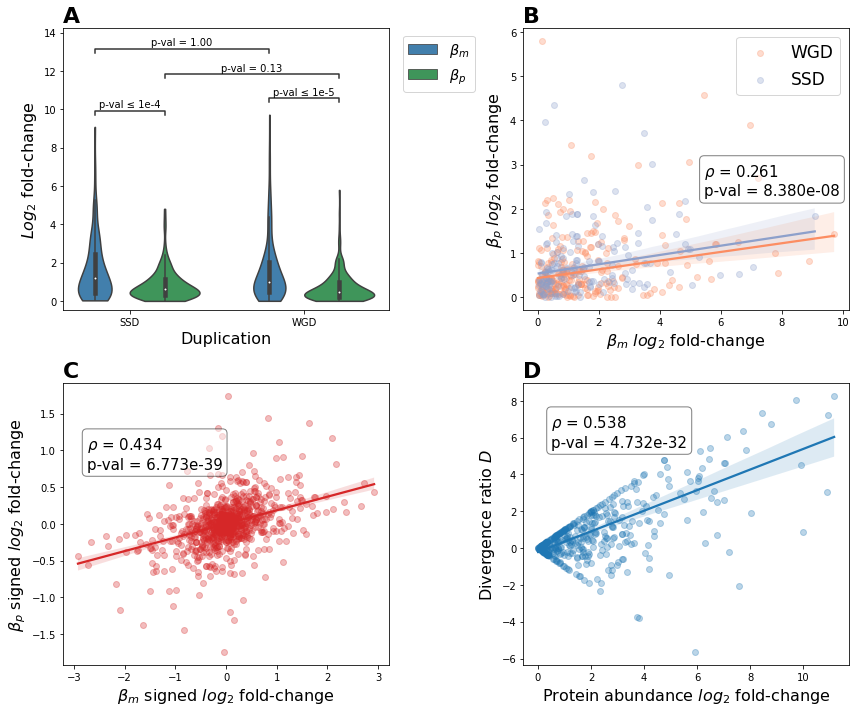

In [29]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subfigure A
diff = sns.violinplot(x='Duplication', y='Log2 fold-change', hue='Property', 
                      data=data_log_original, ax=axs[0, 0], cut=0, 
                      palette={r"$\beta_m$": cm.tab20c.colors[0],
                               r"$\beta_p$": cm.tab20c.colors[8]})

diff.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

add_stat_annotation(diff, data=data_log_original, x='Duplication', 
                    y='Log2 fold-change', hue='Property', 
                    box_pairs=[(('WGD', r"$\beta_m$"), 
                                ('WGD', r"$\beta_p$")),
                               (('WGD', r"$\beta_p$"),
                                ('SSD', r"$\beta_p$")),
                               (('WGD', r"$\beta_m$"), 
                                ('SSD', r"$\beta_m$")),
                               (('SSD', r"$\beta_m$"),
                                ('SSD', r"$\beta_p$"))],
                    test='Mann-Whitney', text_format='simple', loc='inside')

# Subfigure B
sns.regplot(x='Transcription rate', y='Translation rate', data=WGD_data, 
            ax=axs[0, 1], color=cm.Set2.colors[1], scatter_kws={'alpha':0.3}, 
            label='WGD', robust=True)

sns.regplot(x='Transcription rate', y='Translation rate', data=SSD_data, 
            ax=axs[0, 1], color=cm.Set2.colors[2], scatter_kws={'alpha':0.3}, 
            label='SSD', robust=True)

r_div = stats.pearsonr(log_original['Transcription rate'], 
                       log_original['Translation rate'])

axs[0, 1].annotate(r"$\rho$ = "f'{round(r_div[0], 3)}\np-val = {r_div[1]:.3e}',
                (5.45, 2.3), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=15)

axs[0, 1].legend(fontsize=17)

# Subfigure C
#sns.regplot(x='Bm_signed', y='Bp_signed', data=Signed_all[Signed_all['Duplication'] == 'WGD'], ax=axs[1,0], 
            #color=cm.tab10.colors[3],  scatter_kws={'alpha':0.3}, robust=True)

#sns.regplot(x='Bm_signed', y='Bp_signed', data=Signed_all[Signed_all['Duplication'] == 'SSD'], ax=axs[1,0], 
            #color=cm.tab10.colors[4],  scatter_kws={'alpha':0.3}, robust=True)

sns.regplot(x='Bm_signed', y='Bp_signed', data=Signed_all, ax=axs[1,0], 
            color=cm.tab10.colors[3],  scatter_kws={'alpha':0.3}, robust=True)

rho_signed = stats.spearmanr(Signed_all['Bm_signed'], 
                             Signed_all['Bp_signed'])

axs[1,0].annotate(r"$\rho$ = " f'{round(rho_signed[0], 3)}\np-val = {rho_signed[1]:.3e}',
                (-2.75, 0.75), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=15)

# Subfigure D
#sns.regplot(x='pEst_fold_original', y='Div_ratio', 
            #data=couples_divergence[couples_divergence['Duplication'] == 'WGD'], 
            #ax=axs[1,1], scatter_kws={'alpha':0.3}, 
            #label='WGD', robust=True)

#sns.regplot(x='pEst_fold_original', y='Div_ratio', 
            #data=couples_divergence[couples_divergence['Duplication'] == 'SSD'], 
            #ax=axs[1,1], scatter_kws={'alpha':0.3}, 
            #label='WGD', robust=True)

sns.regplot(x='pEst_fold_original', y='Div_ratio', 
            data=couples_divergence, 
            ax=axs[1,1], scatter_kws={'alpha':0.3}, robust=True)

rho_ratio = stats.spearmanr(couples_divergence['pEst_fold_original'], 
                            couples_divergence['Div_ratio'])

axs[1,1].annotate(r"$\rho$ = " f'{round(rho_ratio[0], 3)}\np-val = {rho_ratio[1]:.3e}',
                  (0.5, 5.5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                  fontsize=15)

# Axes labels
axs[0, 0].set_ylabel(r"$Log_{2}$ fold-change", fontsize=16)
axs[0, 0].set_xlabel('Duplication', fontsize=16)

axs[0, 1].set_xlabel(r"$\beta_m$ $log_{2}$ fold-change", fontsize=16)
axs[0, 1].set_ylabel(r"$\beta_p$ $log_{2}$ fold-change", fontsize=16)

axs[1, 0].set_xlabel(r"$\beta_m$ signed $log_2$ fold-change", fontsize=16)
axs[1, 0].set_ylabel(r"$\beta_p$ signed $log_2$ fold-change", fontsize=16)

axs[1, 1].set_xlabel(r"Protein abundance $log_2$ fold-change", fontsize=16)
axs[1, 1].set_ylabel(r"Divergence ratio $D$", fontsize=16)

# Plot ids
axs[0, 0].set_title('A', loc='left', fontsize=22, fontweight="bold")
axs[0, 1].set_title('B', loc='left', fontsize=22, fontweight="bold")
axs[1, 0].set_title('C', loc='left', fontsize=22, fontweight="bold")
axs[1, 1].set_title('D', loc='left', fontsize=22, fontweight="bold")

plt.tight_layout()

Fig1 = plt.gcf()
Fig1.savefig('/content/drive/My Drive/Redaction_SA/Final_figures/Fig1.pdf', bbox_inches='tight')

Before generating the Supp figure 1, we first need to perform the permutations test to assess the true significance of the correlation between the divergence ratio D and log2 fold-change of protein abundance: 

In [25]:
# Defining a function to compute log2 fold-changes
# (Original calculation method, as max/min)
def fold_change(prop_P1, prop_P2, data):
    """Function to calculate log2 fold-change for a property between two duplicates. The two properties are
    provided as dataframe columns, and a dataframe column containing the log2 fold-changes is returned."""

    df = data[[f'{prop_P1}', f'{prop_P2}']].copy()
    df['Fold_Change'] = np.NaN
    df[[f'{prop_P1}', f'{prop_P2}']] = 10**df[[f'{prop_P1}', f'{prop_P2}']]

    for row in range(df.shape[0]):
        value_P1 = df.at[row, f'{prop_P1}']
        value_P2 = df.at[row, f'{prop_P2}']

        if value_P1 == 0 or value_P2 == 0:
            continue

        if value_P1 >= value_P2:
            df.at[row, 'Fold_Change'] = value_P1/value_P2

        elif value_P1 < value_P2:
            df.at[row, 'Fold_Change'] = value_P2/value_P1

    df['Fold_Change'] = np.log2(df['Fold_Change'])

    return df['Fold_Change']

# Should probably define the function differently and use np.apply_along_axes()

In [26]:
# 10000 randomizations of 409 paralog couples are made (with replacement) from
# the dataset. In each case, the divergence ratio is computed in two ways
# (from max/min relative divergences and as the ratio P1/P2), and the magnitude
# of protein abundance divergence is similarly computed in two ways. For each of 
# these calculation methods, the spearman correlation between the two parameters
# is computed and compared to the one obtained from the true pairs of paralogs.

rand_div_corr = pd.DataFrame(columns=['corr_original', 'corr_P1P2'])

df_model = pd.DataFrame(columns=['Bm_P1', 'Bm_P2', 'Bp_P1', 'Bp_P2', 'pEst_P1',
                                 'pEst_P2', 'Bm_fold', 'Bp_fold', 'pEst_fold',
                                 'Bm_P1P2', 'Bp_P1P2', 'pEst_P1P2', 
                                 'Div_original', 'Div_P1P2'], index=range(409))

# Constants
alpha_m = 5.1
alpha_p = 1.34

# Log10 Bm and Bp data to sample randomly
P1_data = couples_divergence[['bm_P1', 'bp_P1']].to_numpy().flatten()
P2_data = couples_divergence[['bm_P2', 'bp_P2']].to_numpy().flatten()

# Initialization of the random number generator
seed = 42
rng = np.random.default_rng(seed)

n = 10000

for step in range(n):
  data = df_model.copy()

  data[['Bm_P1', 'Bp_P1']] = rng.choice(P1_data, (409, 2), replace=True)
  data[['Bm_P2', 'Bp_P2']] = rng.choice(P2_data, (409, 2), replace=True)
  data = data.astype({'Bm_P1': 'float64', 'Bm_P2': 'float64', 
                      'Bp_P1': 'float64', 'Bp_P2': 'float64'})
  data['pEst_P1'] = np.log10((10**data['Bm_P1'] * 10**data['Bp_P1']) / (alpha_m * alpha_p))
  data['pEst_P2'] = np.log10((10**data['Bm_P2'] * 10**data['Bp_P2']) / (alpha_m * alpha_p))
  data['Bm_fold'] = fold_change('Bm_P1', 'Bm_P2', data)
  data['Bp_fold'] = fold_change('Bp_P1', 'Bp_P2', data)
  data['pEst_fold'] = fold_change('pEst_P1', 'pEst_P2', data)
  data['Bm_P1P2'] = np.log2(10**data['Bm_P1'] / 10**data['Bm_P2'])
  data['Bp_P1P2'] = np.log2(10**data['Bp_P1'] / 10**data['Bp_P2'])
  data['pEst_P1P2'] = np.log2(10**data['pEst_P1'] / 10**data['pEst_P2'])
  data['Div_original'] = data['Bm_fold'] - data['Bp_fold']
  data['Div_P1P2'] = data['Bm_P1P2'] - data['Bp_P1P2']

  corr_original = stats.spearmanr(data['pEst_fold'], data['Div_original'])[0]
  corr_P1P2 = stats.spearmanr(data['pEst_P1P2'], data['Div_P1P2'])[0]

  rand_div_corr.at[step, 'corr_original'] = corr_original
  rand_div_corr.at[step, 'corr_P1P2'] = corr_P1P2

## Construction of Supplementary figure 1 ##

In [27]:
# To obtain the desired legend labels
rates_vars = {'Transcription rate': r"$\beta_m$", 
              'Translation rate': r"$\beta_p$"}

for row in range(data_log_original.shape[0]):
  data_diff_original.at[row, 'Property'] = rates_vars[data_diff_original.at[row, 'Property']]

WGD_$\beta_m$ v.s. WGD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=8.775e-12 U_stat=4.102e+04
SSD_$\beta_m$ v.s. SSD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=2.685e-05 U_stat=1.732e+04
SSD_$\beta_p$ v.s. WGD_$\beta_p$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.250e-01 U_stat=2.261e+04
SSD_$\beta_m$ v.s. WGD_$\beta_m$: Mann-Whitney-Wilcoxon test two-sided with Bonferroni correction, P_val=1.000e+00 U_stat=2.052e+04


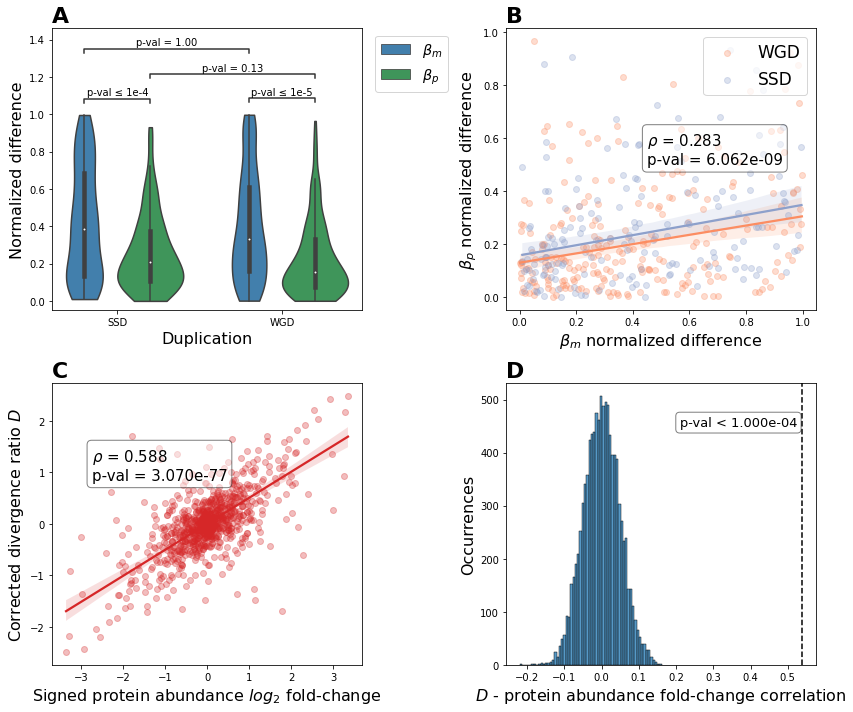

In [31]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Subfigure A
diff = sns.violinplot(x='Duplication', y='Normalized difference', hue='Property', 
                      data=data_diff_original, ax=axs[0, 0], cut=0, 
                      palette={r"$\beta_m$": cm.tab20c.colors[0],
                               r"$\beta_p$": cm.tab20c.colors[8]})

diff.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize='x-large')

add_stat_annotation(diff, data=data_diff_original, x='Duplication', 
                    y='Normalized difference', hue='Property', 
                    box_pairs=[(('WGD', r"$\beta_m$"), 
                                ('WGD', r"$\beta_p$")),
                               (('WGD', r"$\beta_p$"),
                                ('SSD', r"$\beta_p$")),
                               (('WGD', r"$\beta_m$"), 
                                ('SSD', r"$\beta_m$")),
                               (('SSD', r"$\beta_m$"),
                                ('SSD', r"$\beta_p$"))],
                    test='Mann-Whitney', text_format='simple', loc='inside')

# Subfigure B
sns.regplot(x='Transcription rate', y='Translation rate', data=WGD_diff, 
            ax=axs[0, 1], color=cm.Set2.colors[1], scatter_kws={'alpha':0.3}, 
            label='WGD', robust=True)

sns.regplot(x='Transcription rate', y='Translation rate', data=SSD_diff, 
            ax=axs[0, 1], color=cm.Set2.colors[2], scatter_kws={'alpha':0.3}, 
            label='SSD', robust=True)

r_div = stats.pearsonr(diff_original['Transcription rate'], 
                       diff_original['Translation rate'])

axs[0, 1].annotate(r"$\rho$ = "f'{round(r_div[0], 3)}\np-val = {r_div[1]:.3e}',
                (0.45, 0.5), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=15)

axs[0, 1].legend(fontsize=17, loc='upper right')

# Subfigure C
sns.regplot(x='pEst_signed', y='ratio_signed', data=Signed_all, 
            ax=axs[1,0], color=cm.tab10.colors[3], scatter_kws={'alpha':0.3},
            robust=True)

rho_signed = stats.spearmanr(Signed_all['pEst_signed'], 
                             Signed_all['ratio_signed'])

axs[1,0].annotate(r"$\rho$ = " f'{round(rho_signed[0], 3)}\np-val = {rho_signed[1]:.3e}',
                (-2.75, 0.85), bbox=dict(boxstyle='round', fc='w', alpha=0.5),
                 fontsize=15)

# Subfigure D
sns.histplot(data=rand_div_corr['corr_original'], ax=axs[1,1])
#sns.histplot(data=rand_div_corr['corr_P1P2'], ax=axs[1,1])
corr_emp = stats.spearmanr(couples_divergence['pEst_fold_original'], 
                           couples_divergence['Div_ratio'])[0]

p_val = np.where(np.abs(rand_div_corr['corr_original']) >= np.abs(corr_emp))[0].shape[0] / n

axs[1,1].axvline(corr_emp, color='k', linestyle='--')

if p_val == 0:
  axs[1,1].annotate(f'p-val < {1/n:.3e}',(corr_emp - (0.61*corr_emp), 450), 
                bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=13)
  
else:
  axs[1,1].annotate(f'p-val = {p_val:.3e}',(corr_emp - (0.61*corr_emp), 450), 
                  bbox=dict(boxstyle='round', fc='w', alpha=0.5), fontsize=13)
  
# Axes titles
axs[0, 0].set_ylabel('Normalized difference', fontsize=16)
axs[0, 0].set_xlabel('Duplication', fontsize=16)

axs[0, 1].set_xlabel(r"$\beta_m$ normalized difference", fontsize=16)
axs[0, 1].set_ylabel(r"$\beta_p$ normalized difference", fontsize=16)

axs[1, 0].set_xlabel(r"Signed protein abundance $log_2$ fold-change", fontsize=16)
axs[1, 0].set_ylabel(r"Corrected divergence ratio $D$", fontsize=16)

axs[1, 1].set_xlabel(r"$D$ - protein abundance fold-change correlation", 
                     fontsize=16)
axs[1, 1].set_ylabel(r"Occurrences", fontsize=16)

# Plot ids
axs[0, 0].set_title('A', loc='left', fontsize=22, fontweight="bold")
axs[0, 1].set_title('B', loc='left', fontsize=22, fontweight="bold")
axs[1, 0].set_title('C', loc='left', fontsize=22, fontweight="bold")
axs[1, 1].set_title('D', loc='left', fontsize=22, fontweight="bold")

plt.tight_layout()

Supp1 = plt.gcf()
Supp1.savefig('/content/drive/My Drive/Redaction_SA/Final_figures/SuppFig1.pdf', bbox_inches='tight')